# III. Mô hình hoá

## Import các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os

# visualization
import seaborn as sns

# model
from sklearn.linear_model import Ridge, LinearRegression, Lasso
 
# metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import r2_score, make_scorer, mean_squared_error
import joblib

# hyperparameters tunning
from sklearn.model_selection import GridSearchCV

## Load dataset đã được preprocessed

In [2]:
df = pd.read_csv("../Data/preprocessed/cleaned_dataset.csv")
df.head()

,Company,Year,EPS ($),Earnings ($B),Revenue ($B),Marketcap ($B),Total Debts ($B),Net Assets ($B),Total Assets ($B),Cash on hand ($B),Country,Share price ($),Categories
0,Apple,2023,6.16,114.30,383.28,3043.0,111.08,62.14,352.58,61.55,USA,195.71,"Software, Tech, Electronics, Dow jones, Tech H..."
1,Apple,2022,5.92,113.96,387.53,2066.0,120.06,50.67,352.75,48.30,USA,195.71,"Software, Tech, Electronics, Dow jones, Tech H..."
2,Apple,2021,6.08,116.90,378.32,2901.0,124.71,63.09,351.00,62.63,USA,195.71,"Software, Tech, Electronics, Dow jones, Tech H..."
3,Apple,2020,3.74,74.25,294.13,2255.0,112.43,65.33,323.88,90.94,USA,195.71,"Software, Tech, Electronics, Dow jones, Tech H..."
4,Apple,2019,3.19,66.15,267.68,1287.0,108.04,90.48,338.51,100.55,USA,195.71,"Software, Tech, Electronics, Dow jones, Tech H..."


# Dự đoán giá trị `Marketcap($B)` năm tiếp theo dựa trên thông tin năm trước của các công ty thuộc danh mục phần mềm ở USA

**Mục tiêu**

Xây dựng một mô hình dự đoán giá trị Marketcap ($B) năm tiếp theo của các công ty thuộc danh mục phần mềm ở USA dựa trên dữ liệu năm trước đó.

**Ý nghĩa**

- Giúp các nhà đầu tư đưa ra quyết định đầu tư hiệu quả hơn.
- Phân tích xu hướng của thị trường phần mềm ở USA.


Lấy ra các obseravtion thoả 2 điều kiện sau:

- Danh mục: `Categories` có chứa `Software`

- Địa điểm: `Country` là `USA`

In [3]:
#software_cat_mask = df["Categories"].apply(lambda x: True if "Software" in x.split(", ") else False)
software_cat_mask = df["Categories"].str.contains('Software')

usa_mask = df["Country"] == "USA"

cleaned_df = df[software_cat_mask & usa_mask].copy()
print("Shape:", cleaned_df.shape)

Shape: (1610, 13)


Bởi vì phạm vi đang xét là trên danh mục `Software` cho nên cột `Categories` không còn cần thiết nữa. Tương tự cho cột `Country`.

In [4]:
cleaned_df.drop(columns=["Categories", "Country"], axis = 1,inplace=True)
cleaned_df.head()

,Company,Year,EPS ($),Earnings ($B),Revenue ($B),Marketcap ($B),Total Debts ($B),Net Assets ($B),Total Assets ($B),Cash on hand ($B),Share price ($)
0,Apple,2023,6.16,114.30,383.28,3043.0,111.08,62.14,352.58,61.55,195.71
1,Apple,2022,5.92,113.96,387.53,2066.0,120.06,50.67,352.75,48.30,195.71
2,Apple,2021,6.08,116.90,378.32,2901.0,124.71,63.09,351.00,62.63,195.71
3,Apple,2020,3.74,74.25,294.13,2255.0,112.43,65.33,323.88,90.94,195.71
4,Apple,2019,3.19,66.15,267.68,1287.0,108.04,90.48,338.51,100.55,195.71


In [5]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1610 entries, 0 to 38087
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company            1610 non-null   object 
 1   Year               1610 non-null   int64  
 2   EPS ($)            1610 non-null   float64
 3   Earnings ($B)      1610 non-null   float64
 4   Revenue ($B)       1610 non-null   float64
 5   Marketcap ($B)     1610 non-null   float64
 6   Total Debts ($B)   1610 non-null   float64
 7   Net Assets ($B)    1610 non-null   float64
 8   Total Assets ($B)  1610 non-null   float64
 9   Cash on hand ($B)  1610 non-null   float64
 10  Share price ($)    1610 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 150.9+ KB


**Nhận xét**

- Không có missing-value

- Kiểu dữ liệu cho các cột là hợp lý

In [6]:
# Kiểm tra số năm mỗi công ty
year_per_company = cleaned_df.groupby('Company')['Marketcap ($B)'].count().sort_values()

print("Số dòng dữ liệu môi công ty là:\n", year_per_company)

Số dòng dữ liệu môi công ty là:
 Company
Adobe                   23
MongoDB                 23
National Instruments    23
NetApp                  23
Nutanix                 23
                        ..
Enphase Energy          23
Elastic NV              23
EPAM Systems            23
Fortinet                23
Zscaler                 23
Name: Marketcap ($B), Length: 70, dtype: int64


Do mỗi công ty đều có đủ 23 dòng tương ứng với 23 năm nên ta có thể dùng lệnh shift để thêm cột `Next_Year_Marketcap` chứa Marketcap của năm tiếp theo cho từng công ty

In [7]:
# Tạo một cột mới 'Next_Year_Marketcap' chứa Marketcap của năm tiếp theo cho từng công ty
cleaned_df['Next_Year_Marketcap ($B)'] = cleaned_df.groupby('Company')['Marketcap ($B)'].shift(1)
# Loại bỏ dòng năm 2023 do không có dữ liệu năm kế tiếp
cleaned_df.dropna(subset=['Next_Year_Marketcap ($B)'], inplace=True)
cleaned_df.head(10)


,Company,Year,EPS ($),Earnings ($B),Revenue ($B),Marketcap ($B),Total Debts ($B),Net Assets ($B),Total Assets ($B),Cash on hand ($B),Share price ($),Next_Year_Marketcap ($B)
1,Apple,2022,5.92,113.96,387.53,2066.00,120.06,50.67,352.75,48.30,195.71,3043.00
2,Apple,2021,6.08,116.90,378.32,2901.00,124.71,63.09,351.00,62.63,195.71,2066.00
3,Apple,2020,3.74,74.25,294.13,2255.00,112.43,65.33,323.88,90.94,195.71,2901.00
4,Apple,2019,3.19,66.15,267.68,1287.00,108.04,90.48,338.51,100.55,195.71,2255.00
5,Apple,2018,3.07,67.97,261.61,746.07,114.48,107.14,365.72,66.30,195.71,1287.00
6,Apple,2017,2.45,64.25,239.17,860.88,115.68,134.04,375.31,74.18,195.71,746.07
7,Apple,2016,2.10,59.21,218.11,608.96,87.03,128.24,321.68,67.15,195.71,860.88
8,Apple,2015,2.37,71.15,234.98,583.61,64.46,119.35,290.47,41.60,195.71,608.96
9,Apple,2014,1.87,59.28,199.80,643.12,35.29,111.54,231.83,25.07,195.71,583.61
10,Apple,2013,1.45,49.25,173.99,500.74,16.96,123.54,207.00,40.54,195.71,643.12


## Lựa chọn features

Cột `Company` bây chỉ dùng để nhận diện tên của công ty cho nên cũng không quá cần thiết trong việc dự đoán nên ta sẽ drop luôn.

In [8]:
cleaned_df.drop(columns=["Company"], axis = 1,inplace=True)

Visualize correlation matrix để xem chỉ số tương quan giữa các features và target cần quan tâm

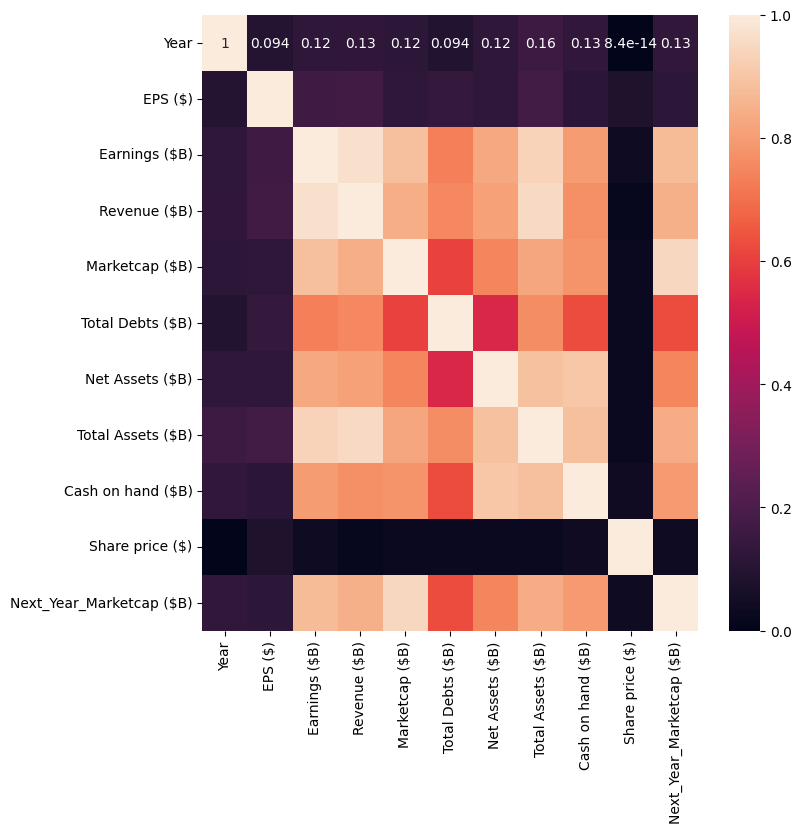

In [9]:
plt.figure(figsize=(8, 8))
sns.heatmap(cleaned_df.corr(), annot=True);

**Nhận xét**

- `Next_Year_Marketcap ($B)` có sự tương quan mạnh (positive) đối với các features: `Earnings`, `Revenue`, `Marketcap`, `Total Debts`, `Net Assets`, `Total Assets` và `Cash on hand`

- Các features còn lại có độ tương quan rất thấp.

- Ta sẽ dùng các features có độ tương quan mạnh để dự đoán target

Visualize bằng `Scatterplot`

/home/binhng/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/binhng/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/binhng/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/binhng/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

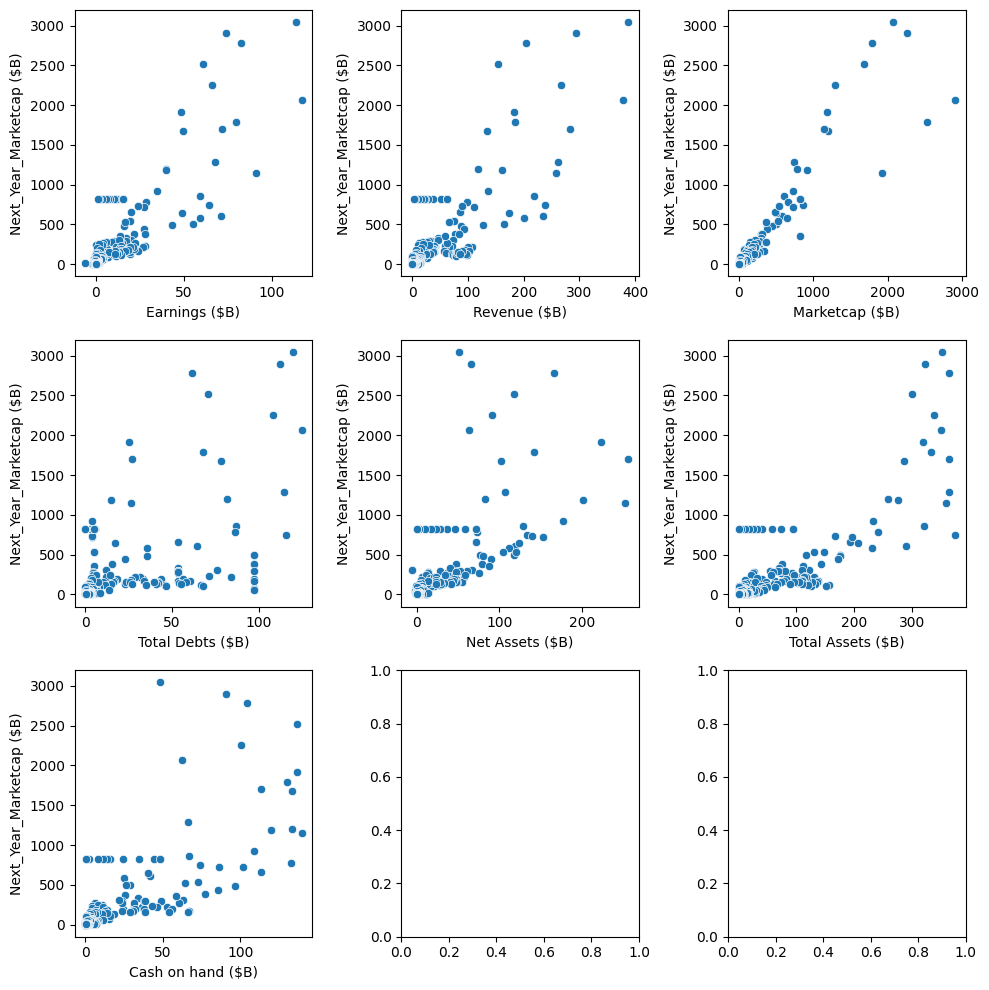

In [10]:


fig, axes = plt.subplots(3, 3, figsize=(10, 10))
feature_names = ['Earnings ($B)', 'Revenue ($B)', 'Marketcap ($B)',
       'Total Debts ($B)', 'Net Assets ($B)', 'Total Assets ($B)', 'Cash on hand ($B)']

axes = axes.flatten()

for i, ax in enumerate(feature_names):
    sns.scatterplot(data=cleaned_df, x=feature_names[i], y='Next_Year_Marketcap ($B)', ax= axes[i])
    
plt.tight_layout()

**Nhận xét**

- Giữa các features và target có positive correlation, khi feature tăng lên thì target cũng có xu hướng tăng theo khá rõ rệt.

## Phân phối của các features

Vẽ boxplot để xem phân bố các giá trị trong features và targets

/home/binhng/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/binhng/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/binhng/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/binhng/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

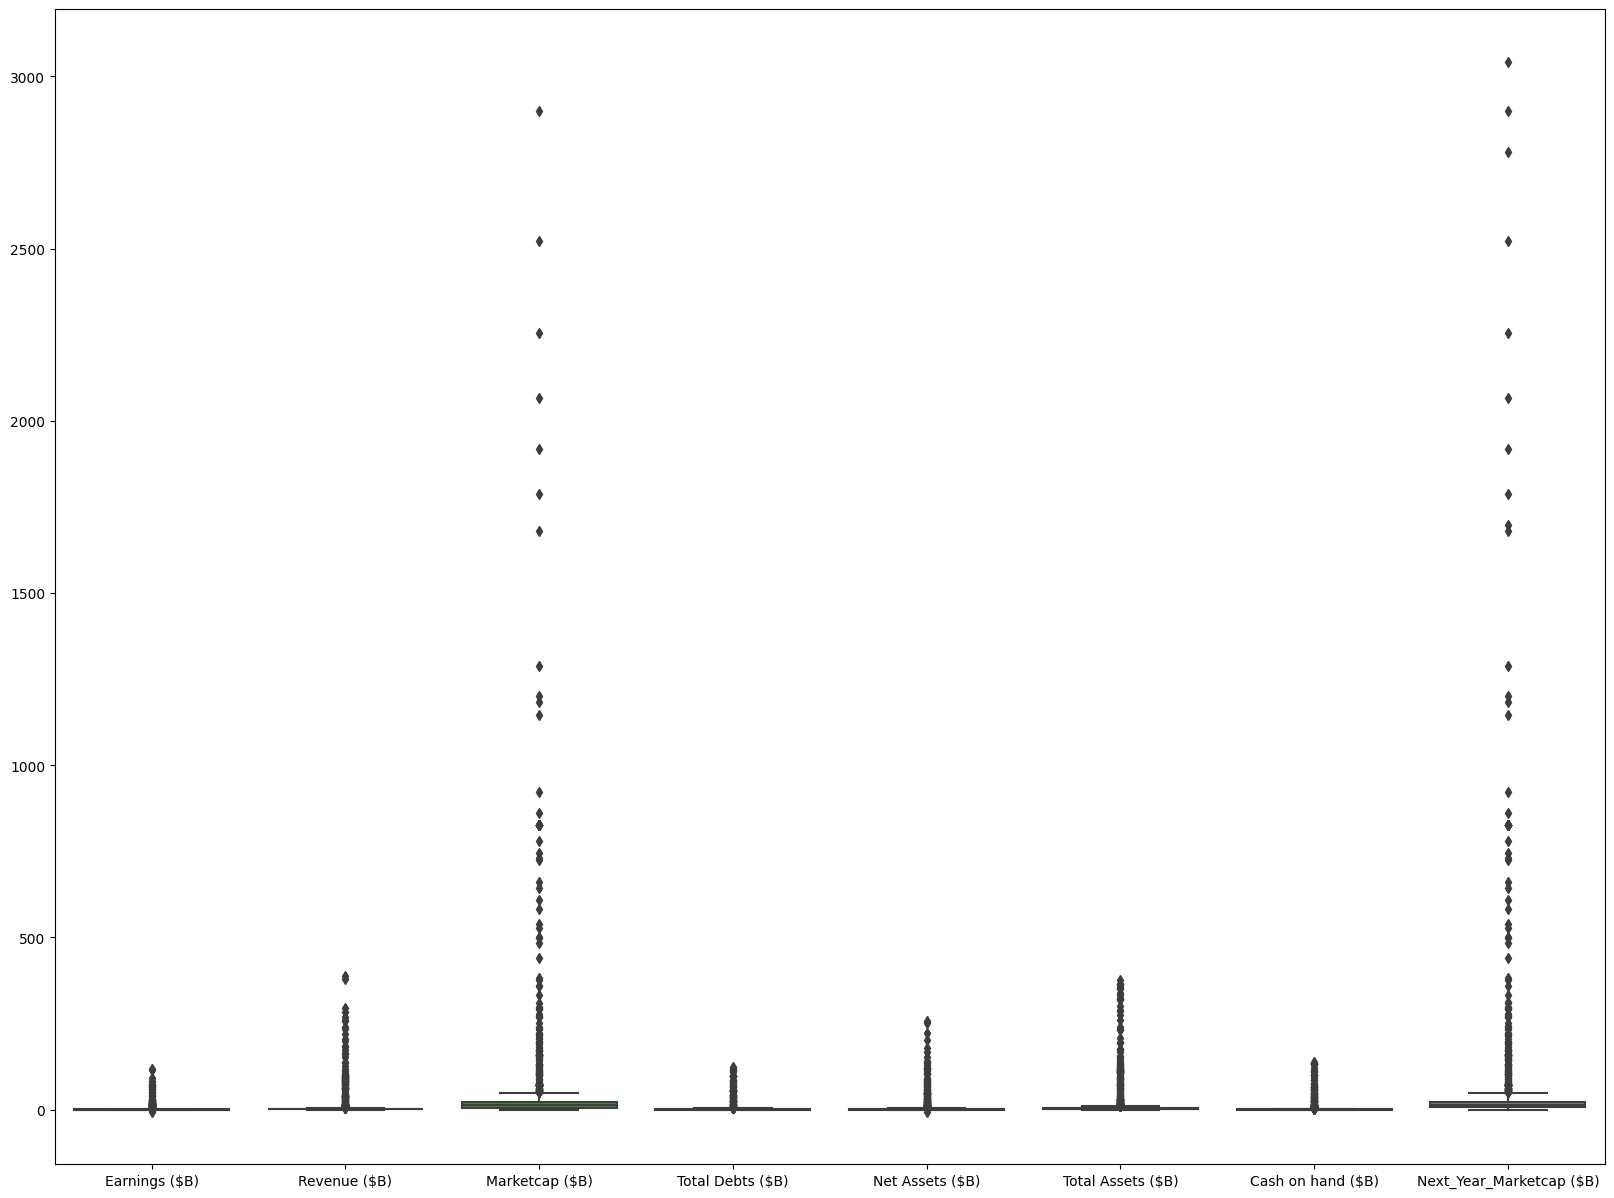

In [11]:
cols = feature_names.copy()
cols.append('Next_Year_Marketcap ($B)')

plt.figure(figsize=(20, 15))
sns.boxplot(data=cleaned_df[cols]);

**Nhận xét**

- Hầu hết tất cả các cột ta quan tâm đều có rất nhiều `outliers`. Tuy nhiên đây là dữ liệu có thật cho nên ta không thể tự ý xoá bỏ.

- Ta sẽ giữ lại tất cả `outliers`

**Tạo tập X và y**

In [12]:
X = cleaned_df[feature_names].values

y = cleaned_df['Next_Year_Marketcap ($B)']

print ("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1540, 7)
y shape: (1540,)


## Mô hình hoá 

Do `target` là một cột `Numerical` cho nên ta sẽ dùng các `regression models` để thực hiện mô hình hoá.

Đánh giá performance bằng `5-fold Cross-Validation` 

In [13]:
default_alpha = 0.1
kfold = KFold(n_splits=5, shuffle=True, random_state=21) 


models = {'Linear Regression': LinearRegression(),
          'Lasso': Lasso(default_alpha),
        'Ridge': Ridge(default_alpha)}

for name, model in models.items():

    scores = cross_val_score(model, X, y, cv=kfold)
    print(f'Mean R-squared of {name}: ', scores.mean())
    
    y_pred = cross_val_predict(model, X, y, cv=kfold)
    mse = mean_squared_error(y, y_pred)
    print(f'Mean Squared Error of {name}: {mse}')


Mean R-squared of Linear Regression:  0.879931191796592
Mean Squared Error of Linear Regression: 5983.95936907856
Mean R-squared of Lasso:  0.8800256469060056
Mean Squared Error of Lasso: 5978.8599044821185
Mean R-squared of Ridge:  0.8799316294679882
Mean Squared Error of Ridge: 5983.937082958918


**Nhận xét**

- Performance của 3 models không quá chênh lệch. Cao nhất là `Lasso`

# Hyperparamater tuning

Tìm giá trị alpha phù hợp với model nhất (trừ Linear Regression)

In [14]:

param_grid = {"alpha": np.linspace(0.001, 1, 100)}


for name, model in models.items():
    if name == 'Linear Regression':
        continue 
    
    model_cv = GridSearchCV(model, param_grid, cv = kfold)

    model_cv.fit(X, y)
    print("Tuned {} paramaters: {}".format(name, model_cv.best_params_))
    print("Tuned {} score: {}".format(name, model_cv.best_score_))

Tuned Lasso paramaters: {'alpha': 1.0}
Tuned Lasso score: 0.8808450168619777
Tuned Ridge paramaters: {'alpha': 1.0}
Tuned Ridge score: 0.8799355673101383


**Nhận xét**

- Best alpha cho cả 2 model `Ridge` và `Lasso` đều là `1.0`

## Scaling dữ liệu

Bởi vì các regression models mà ta sử dụng (`Linear Regression`, `Lasso` và `Ridge`) thường bị tác động bởi `Scaling`, do đó `Scaling` trước khi training cũng có thể cải thiện hiệu suất của mô hình.

**Lưu ý**: cần chia training set và test set trước khi scaling. Bởi vì khi áp dụng `StandardScaler`, ta muốn giá trị `mean` và `std` chỉ được tính dựa trên training set chứ không phải toàn bộ data hiện có.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(1),
    'Ridge': Ridge(1)
}


scaler = StandardScaler()

for name, model in models.items():

    model_pipeline = Pipeline([
        ('scaler', scaler),
        ('model', model)
    ])

    model_pipeline.fit(X, y)

    scores = cross_val_score(model, X, y, scoring='r2', cv=kfold)
    
    y_pred = cross_val_predict(model, X, y, cv=kfold)
    mse = mean_squared_error(y, y_pred)

    print(f'Mean R-squared of {name}: ', scores.mean())
    print(f'Mean Squared Error of {name}: {mse}')
    


    

Mean R-squared of Linear Regression:  0.879931191796592
Mean Squared Error of Linear Regression: 5983.95936907856
Mean R-squared of Lasso:  0.8808450168619777
Mean Squared Error of Lasso: 5934.294674500835
Mean R-squared of Ridge:  0.8799355673101383
Mean Squared Error of Ridge: 5983.7365686855765


## Kết luận

Mô hình Lasso Regression có hiệu suất tốt nhất trong số ba mô hình được xem xét, do:
- R-squared cao nhất: Mô hình Lasso Regression đạt giá trị R-squared trung bình cao nhất (0.8918595734051109), cho thấy khả năng giải thích phương sai cao nhất trong dữ liệu.
- MSE thấp nhất: Mô hình Lasso Regression cũng có giá trị MSE trung bình thấp nhất (5351.082179671501), cho thấy sai số dự đoán thấp nhất.
